# Project template

## Read in the mesh

(255, 6)
(557, 2)
all elements have consistent orientation


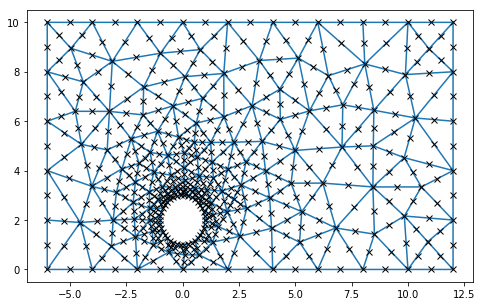

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.sparse as sparse
import scipy.linalg as la
import scipy.sparse.linalg as sla
%matplotlib inline

import gmsh
mesh = gmsh.Mesh()
mesh.read_msh('w1.msh')

# Mesh |  ne   |  nv
#  w1  |  255  |  557
#  w2  |  1020 |  2134
#  w3  |  4080 |  8348

## Quadratic triangle elements
E = mesh.Elmts[9][1]
V = mesh.Verts[:,:2]

ne = E.shape[0]
nv = V.shape[0]
X = V[:,0]
Y = V[:,1]

print(E.shape)
print(V.shape)

def checkorientation(V, E):
    sgn = np.zeros((E.shape[0],))
    for i in range(E.shape[0]):
        xi = V[E[i, :3],0]
        yi = V[E[i, :3],1]
        A = np.zeros((3,3))
        A[:,0] = 1.0
        A[:,1] = xi
        A[:,2] = yi
        sgn[i] = np.linalg.det(A)
    return sgn

sgn = checkorientation(V, E)
I = np.where(sgn<0)[0]
if(I.size==ne or I.size==0):
    print('all elements have consistent orientation')

# plt.figure(figsize=(19,10))
plt.figure(figsize=(8,5))
plt.triplot(X,Y,E[:,:3])
plt.plot(X,Y,'kx')
# plt.tricontourf(X, Y, E[:,:3], (X-5)**2 + (Y-5)**2, 100)
# plt.colorbar()
plt.show()

## Exact solution is provided here

Pressure is not defined on all of the points in V.

In [2]:
def wan_exact(): # Wannier-Stokes
    d = 2.
    r = 1.
    s = np.sqrt(d**2 - r**2)
    gam = (s+d)/(d-s)
    U = 4.
    tmp = 1./np.log(gam)
    A = -(U*d)* tmp
    B = 2.*U*(d+s) * tmp
    C = 2.*U*(d-s) * tmp
    F = U * tmp
    
    from sympy import symbols, exp, log, lambdify, init_printing, diff, simplify
    x,y,k1,k2,u,v=symbols('x y k1 k2 u v')
    k1 = x**2 + (s+y)**2
    k2 = x**2 + (s-y)**2
    
    # # maslanik, sani, gresho
    u = U - F*log(k1/k2)\
          - 2*(A+F*y) *((s+y)+k1*(s-y)/k2) / k1\
          - B*((s+2*y)-2*y*((s+y)**2)/k1)/k1\
          - C*((s-2*y)+2*y*((s-y)**2)/k2)/k2

    v = + 2*x*(A+F*y)*(k2-k1)/(k1*k2)\
        - 2*B*x*y*(s+y)/(k1*k1)\
        - 2*C*x*y*(s-y)/(k2*k2)
        
    p = - 4*B*x*(s+y)/(k1*k1)\
        - 4*C*x*(s-y)/(k2*k2)\
        - 16*F*s*x*y/(k1*k2)

    ue = lambdify([x,y],u,'numpy')
    ve = lambdify([x,y],v,'numpy')
    pe = lambdify([x,y],p,'numpy')
    return ue,ve,pe

In [3]:
# index mapping
E1,Eindex = np.unique(E[:,:3],return_index=True)

index_map = np.zeros(int(np.amax(E1)+1))
index_map[E1] = np.arange(len(E1))
index_map = index_map.astype(int)

X1 = V[E1,0]
Y1 = V[E1,1]

E2 = np.zeros(E[:,:3].shape)
for ei in range(E.shape[0]):
    E2[ei,:] = index_map[E[ei,:3]]

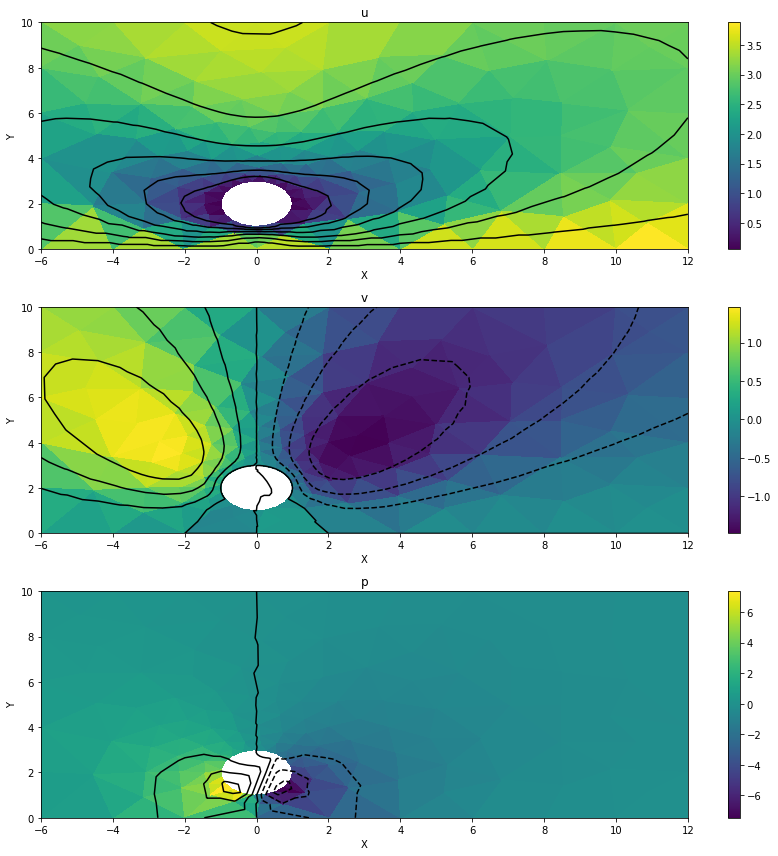

In [4]:
ue, ve, pe = wan_exact()
uex = ue(X,Y)
vex = ve(X,Y)
pex = pe(X1,Y1)
import matplotlib.tri as tri
triang = tri.Triangulation(X,Y)
triang1= tri.Triangulation(X1,Y1)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(3,1,1)
surf = ax.tripcolor(X, Y, uex, triangles=E[:,:3], cmap=plt.cm.viridis, linewidth=0.2)
ax.tricontour(triang, uex, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('u')
fig.colorbar(surf)
fig.tight_layout()
ax = fig.add_subplot(3,1,2)
surf = ax.tripcolor(X, Y, vex, triangles=E[:,:3], cmap=plt.cm.viridis, linewidth=0.2)
ax.tricontour(triang, vex, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('v')
fig.colorbar(surf)
fig.tight_layout()
ax = fig.add_subplot(3,1,3)
surf = ax.tripcolor(X1, Y1, pex, triangles=E2, cmap=plt.cm.viridis, linewidth=0.2)
ax.tricontour(triang1, pex, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('p')
fig.colorbar(surf)
fig.tight_layout()

## Build your matrices

In [5]:
def trigauss(n):
    if (n == 1):
        xw=np.array([0.33333333333333, 0.33333333333333, 1.00000000000000])
    elif (n == 2):
        xw=np.array([[0.16666666666667, 0.16666666666667, 0.33333333333333],
                     [0.16666666666667, 0.66666666666667, 0.33333333333333],
                     [0.66666666666667, 0.16666666666667, 0.33333333333333]])
    elif (n == 3):
        xw=np.array([[0.33333333333333, 0.33333333333333, -0.56250000000000],
                     [0.20000000000000, 0.20000000000000, 0.52083333333333],
                     [0.20000000000000, 0.60000000000000, 0.52083333333333],
                     [0.60000000000000, 0.20000000000000, 0.52083333333333]])
    elif (n == 4):
        xw=np.array([[0.44594849091597, 0.44594849091597, 0.22338158967801],
                     [0.44594849091597, 0.10810301816807, 0.22338158967801],
                     [0.10810301816807, 0.44594849091597, 0.22338158967801],
                     [0.09157621350977, 0.09157621350977, 0.10995174365532],
                     [0.09157621350977, 0.81684757298046, 0.10995174365532],
                     [0.81684757298046, 0.09157621350977, 0.10995174365532]])
    elif (n == 5):
        xw=np.array([[0.33333333333333, 0.33333333333333, 0.22500000000000],
                     [0.47014206410511, 0.47014206410511, 0.13239415278851],
                     [0.47014206410511, 0.05971587178977, 0.13239415278851],
                     [0.05971587178977, 0.47014206410511, 0.13239415278851],
                     [0.10128650732346, 0.10128650732346, 0.12593918054483],
                     [0.10128650732346, 0.79742698535309, 0.12593918054483],
                     [0.79742698535309, 0.10128650732346, 0.12593918054483]])
    elif (n == 6):
        xw=np.array([[0.24928674517091, 0.24928674517091, 0.11678627572638 ],
                     [0.24928674517091, 0.50142650965818, 0.11678627572638 ],
                     [0.50142650965818, 0.24928674517091, 0.11678627572638 ],
                     [0.06308901449150, 0.06308901449150, 0.05084490637021 ],
                     [0.06308901449150, 0.87382197101700, 0.05084490637021 ],
                     [0.87382197101700, 0.06308901449150, 0.05084490637021 ],
                     [0.31035245103378, 0.63650249912140, 0.08285107561837 ],
                     [0.63650249912140, 0.05314504984482, 0.08285107561837 ],
                     [0.05314504984482, 0.31035245103378, 0.08285107561837 ],
                     [0.63650249912140, 0.31035245103378, 0.08285107561837 ],
                     [0.31035245103378, 0.05314504984482, 0.08285107561837 ],
                     [0.05314504984482, 0.63650249912140, 0.08285107561837]])
    elif (n == 7):
        xw=np.array([[0.33333333333333, 0.33333333333333, -0.14957004446768],
                     [0.26034596607904, 0.26034596607904, 0.17561525743321 ],
                     [0.26034596607904, 0.47930806784192, 0.17561525743321 ],
                     [0.47930806784192, 0.26034596607904, 0.17561525743321 ],
                     [0.06513010290222, 0.06513010290222, 0.05334723560884 ],
                     [0.06513010290222, 0.86973979419557, 0.05334723560884 ],
                     [0.86973979419557, 0.06513010290222, 0.05334723560884 ],
                     [0.31286549600487, 0.63844418856981, 0.07711376089026 ],
                     [0.63844418856981, 0.04869031542532, 0.07711376089026 ],
                     [0.04869031542532, 0.31286549600487, 0.07711376089026 ],
                     [0.63844418856981, 0.31286549600487, 0.07711376089026 ],
                     [0.31286549600487, 0.04869031542532, 0.07711376089026 ],
                     [0.04869031542532, 0.63844418856981, 0.07711376089026]])
    elif (n >= 8):
        if(n>8):
            print('trigauss: Too high, taking n = 8')
        xw=np.array([[0.33333333333333, 0.33333333333333, 0.14431560767779],
                     [0.45929258829272, 0.45929258829272, 0.09509163426728],
                     [0.45929258829272, 0.08141482341455, 0.09509163426728],
                     [0.08141482341455, 0.45929258829272, 0.09509163426728],
                     [0.17056930775176, 0.17056930775176, 0.10321737053472],
                     [0.17056930775176, 0.65886138449648, 0.10321737053472],
                     [0.65886138449648, 0.17056930775176, 0.10321737053472],
                     [0.05054722831703, 0.05054722831703, 0.03245849762320],
                     [0.05054722831703, 0.89890554336594, 0.03245849762320],
                     [0.89890554336594, 0.05054722831703, 0.03245849762320],
                     [0.26311282963464, 0.72849239295540, 0.02723031417443],
                     [0.72849239295540, 0.00839477740996, 0.02723031417443],
                     [0.00839477740996, 0.26311282963464, 0.02723031417443],
                     [0.72849239295540, 0.26311282963464, 0.02723031417443],
                     [0.26311282963464, 0.00839477740996, 0.02723031417443],
                     [0.00839477740996, 0.72849239295540, 0.02723031417443]])

    qx = xw[:,:2]
    qw = xw[:,2]/2
    return qx, qw



In [6]:
def diffbasis_func(r,s):
    deri_basis=np.array([[4*s+4*r-3, 4*r-1, 0,4-8*r-4*s,4*s,-4*s],
              [4*s+4*r-3, 0, 4*s-1,-4*r,4*r,4-4*r-8*s]])
    return deri_basis
def basis_func(r,s):
    basis=np.array([(1-r-s)*(1-2*r-2*s),-r*(1-2*r),-s*(1-2*s),4*r*(1-r-s),4*r*s,4*s*(1-r-s)])
    return basis
def psbasis_func(r,s):
    ps_basis=np.array([1-r-s,r,s])
    return ps_basis

In [7]:
qx,qw=trigauss(6)

AA = np.zeros((ne, 36))
IA = np.zeros((ne, 36))
JA = np.zeros((ne, 36))
Dx_= np.zeros((ne, 18))
Dy_= np.zeros((ne, 18))
iD = np.zeros((ne, 18))
jD = np.zeros((ne, 18))


for ei in range(ne):
    # Step 1
    K = E[ei, :]
    x0, y0 = X[K[0]], Y[K[0]]
    x1, y1 = X[K[1]], Y[K[1]]
    x2, y2 = X[K[2]], Y[K[2]]


    # Step 2
    J = np.array([[x1 - x0, x2 - x0],
                  [y1 - y0, y2 - y0]])
    invJ = la.inv(J.T)
    detJ = la.det(J)

    # Step 3
    dbasis=[]
    basis=[]
    for i in range(np.shape(qx)[0]):
        dbasis.append(diffbasis_func(qx[i,0],qx[i,1]))
        basis.append(basis_func(qx[i,0],qx[i,1]))

    # Step 4
    dphi=[]
    for i in range(np.shape(qx)[0]):
        dphi.append(invJ.dot(dbasis[i]))
#     print(np.shape(dphi))

    # Step 5
    Aelem=np.zeros((6,6))
    for i in range(np.shape(qx)[0]):
        Aelem=Aelem+detJ*(qw[i]*(dphi[i].T).dot(dphi[i]))

    # Step 6
    n = len(qw)
    Dxelem = 0.0
    Dyelem = 0.0
    for i in range(n):
        r,s = qx[i]
        w = qw[i]
        Dxelem+=np.outer(psbasis_func(r,s),dphi[i].T[:,0])*detJ*w
        Dyelem+=np.outer(psbasis_func(r,s),dphi[i].T[:,1])*detJ*w
#         print(dphi[i].T[:,0])
#     print(Dxelem)
#     print(Dyelem)
    # Step 7, Assembly
    KK = np.tile(K,(6,1))
    AA[ei,:] = Aelem.ravel()
    IA[ei,:] = KK.flatten(order='F')
    JA[ei,:] = KK.flatten()
    Dx_[ei,:] = Dxelem.ravel()
    Dy_[ei,:] = Dyelem.ravel()
    iD[ei,:] = index_map[ KK[:,:3].flatten(order='F') ]
    jD[ei,:] = KK.flatten()[:18] 

#convert back to COO for easier manipulation.
A_ = sparse.coo_matrix((AA.ravel(), (IA.ravel(), JA.ravel())))
A_ = A_.tocsr()
A_ = A_.tocoo()
Dx = sparse.coo_matrix((Dx_.ravel(), (iD.ravel(), jD.ravel())))
Dy = sparse.coo_matrix((Dy_.ravel(), (iD.ravel(), jD.ravel())))
Dx = Dx.tocsr()
Dx = Dx.tocoo()
Dy = Dy.tocsr()
Dy = Dy.tocoo()
# print(Dx)
# print(Dy)

## Apply boundary conditions

There are two sets of Dirichlet boundaries:

 - the cylinder surface
 - the rectangle sides

In [8]:
# Locations of the Wannier boundary 
tol = 1.e-12
tol2 = 1.e-6
Dflag1 = np.array((abs(np.power(X,2.)+np.power(Y-2.,2.)-1.) < tol))
Dflag2 = np.logical_or.reduce((abs(X+6. ) < tol2,
                               abs(X-12.) < tol2,
                               abs(Y+0.)  < tol2,
                               abs(Y-10.) < tol2))

ID1 = np.where(Dflag1)[0]
ID2 = np.where(Dflag2)[0]
Dflag = np.logical_or(Dflag1,Dflag2)
ID = np.where(Dflag)[0]
IDc = np.where(Dflag==False)[0]

print(ID.size,IDc.size)


94 463


## Solve the system

In [9]:
R = sparse.coo_matrix((np.ones(IDc.size),(np.arange(IDc.size), IDc )))
R = R.tocsr()
R = R.tocoo()
R_trans = R.transpose()

ux = np.zeros(nv)
uy = np.zeros(nv)
ux[ID] = uex[ID]
uy[ID] = vex[ID]

A = (R.dot(A_)).dot(R_trans)
A = A.tocsc()
A_inv = sla.inv(A)

Sx = -Dx.dot(R_trans).dot(A_inv).dot(R).dot(Dx.transpose())
Sy = -Dy.dot(R_trans).dot(A_inv).dot(R).dot(Dy.transpose())
S = Sx + Sy

fu = -A_.dot(ux)
fv = -A_.dot(uy)
fp = Dx.dot(ux) + Dy.dot(uy) + Dx.dot(R_trans.dot(A_inv).dot(R.dot(fu))) + Dy.dot(R_trans.dot(A_inv).dot(R.dot(fv)))

p=np.linalg.pinv(S.toarray()).dot(fp)
u = R_trans.dot(A_inv.dot(R.dot(fu)+R.dot(Dx.transpose().dot(p)))) + ux
v = R_trans.dot(A_inv.dot(R.dot(fv)+R.dot(Dy.transpose().dot(p)))) + uy

p_err=la.norm(pex-p,2)
u_err=la.norm(uex-u,2)
v_err=la.norm(vex-v,2)
print(p_err)
print(u_err)
print(v_err)

2.549458156144076
0.5213487659581957
0.6283158776714345


## Post-processing

Plot solution, find convergence rate, etc.

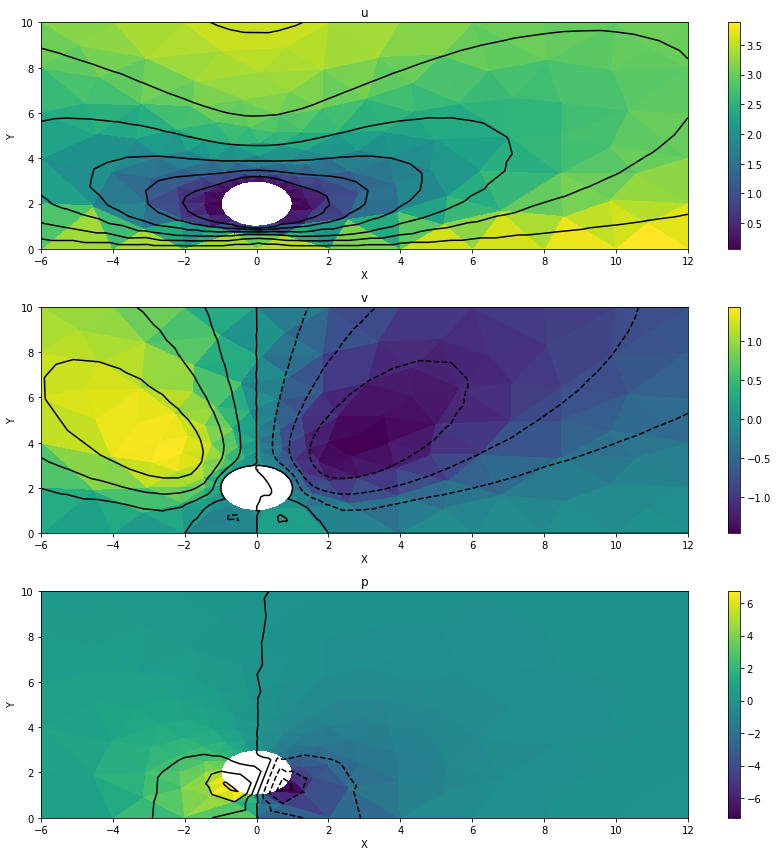

In [10]:
# Part 1.1
fig = plt.figure(figsize=(12,12))
triang = tri.Triangulation(X,Y)
triang1= tri.Triangulation(X1,Y1)
ax = fig.add_subplot(3,1,1)
surf = ax.tripcolor(X, Y, u, triangles=E[:,:3], cmap=plt.cm.viridis, linewidth=0.2)
ax.tricontour(triang, u, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('u')
fig.colorbar(surf)
fig.tight_layout()
ax = fig.add_subplot(3,1,2)
surf = ax.tripcolor(X, Y, v, triangles=E[:,:3], cmap=plt.cm.viridis, linewidth=0.2)
ax.tricontour(triang, v, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('v')
fig.colorbar(surf)
fig.tight_layout()
ax = fig.add_subplot(3,1,3)
surf = ax.tripcolor(X1, Y1, p,triangles=E2, cmap=plt.cm.viridis, linewidth=0.2)
ax.tricontour(triang1, p, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('p')
fig.colorbar(surf)
fig.tight_layout()


It’s 2nd order convergence rate.


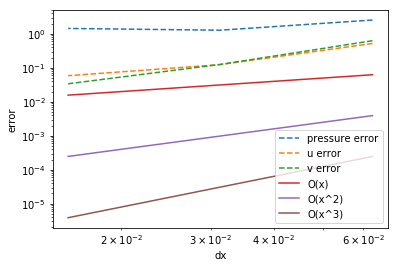

In [13]:
# Part 1.2
p_err_list=[2.549458156144076,1.280772298565427,1.4413269271805496]
u_err_list=[0.5213487659581957,0.12397310240306317,0.05872721596754134]
v_err_list=[0.6283158776714345,0.1257340605185786,0.03387949386684419]
dx=np.array([0.0626,0.0313,0.0157])
plt.figure()
plt.loglog(dx,p_err_list,"--", label='pressure error')
plt.loglog(dx,u_err_list,"--", label='u error')
plt.loglog(dx,v_err_list, "--",label='v error')
plt.loglog(dx,dx,label='O(x)')
plt.loglog(dx,dx**2,label='O(x^2)')
plt.loglog(dx,dx**3,label='O(x^3)')
# plt.loglog(dx,dx**4,label='O(x^4)')
plt.xlabel('dx')
plt.ylabel('error')    
plt.legend(frameon=True)
print("It’s 2nd order convergence rate for u and v, 1st order convergence rate for p.")

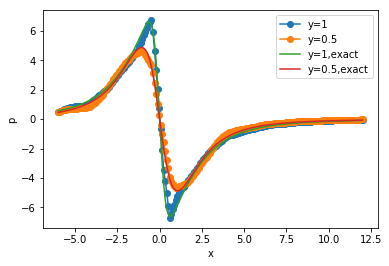

In [12]:
# Part 1.3
from scipy.interpolate import LinearNDInterpolator
psol= LinearNDInterpolator(np.vstack([X1,Y1]).T,p)
x=np.linspace(-6,12,200)
y=np.ones(200)
plt.plot(x,psol(np.vstack([x,y]).T),'o-',label="y=1")
plt.plot(x,psol(np.vstack([x,0.5*y]).T),'o-',label="y=0.5")
plt.plot(x,pe(x,y),label="y=1,exact")
plt.plot(x,pe(x,0.5*y),label="y=0.5,exact")
plt.legend()
plt.ylabel("p")
plt.xlabel("x")
plt.show()